# Autoencoder with Keras

## 目录
- [1. Autoencoder 简介](#1.-Autoencoder 简介)
- [2. 自编码器](#2.-自编码器)
    - [2.1 基于全连接的简单自编码器（Baseline）](#2.1-基于全连接的简单自编码器（Baseline）)
    - [2.2 稀疏自编码（对Encoder层的输出进行限制](#2.2-稀疏自编码（对Encoder层的输出进行限制）)
    - [2.3 深度自编码器(对编码器和解码器的网络的深度进行扩展)](#2.3-深度自编码器(对编码器和解码器的网络的深度进行扩展))
    - [2.4 深度卷积自编码器器](#2.4-深度卷积自编码器器)
        

# 1. Autoencoder 简介

自编码器(Autoencoder):顾名思义,自编码器可以拆分为:自+编码器,当然有了编码器,自然对应的就会存在解码器,所以自编码器就可以理解为:自+编码器+解码器,用下图来解释就是,我们先将原始的数据通过某种操作进行(神经网络)**编码**得到加密数据A,然后我们对加密数据A进行**解码(神经网络)**得到解码后的数据B,而串联加密和解密设计的就是我们的**损失函数**,自编码中的损失函数的设计和我们的输入数据相关,它的Target或者Label就是我们的输入,所以我们可以认为这是一个**自**学习的过程,这就是我们的自编码器.
![](../data/images/autoencoder_schema.jpg)

在自编码器中,中间加密的数据的维度往往较低,因此自编码常常被用作降维操作等,不过实践中我们发现,在图片压缩等问题中,训练的自编码器的加密效果相比于JPEG之类的方法效果还是相对较差的。

不过自编码器本就不是专门用来做数据压缩的,它一个非常大的作用就是可以用作很多神经网络的预训练[2],从而帮助提高模型的准确率;此外它还可以帮助我们进行数据去噪处理以及低维数据可视化来辅助我们挖掘数据内部的结构特性等。不仅如此,自编码器还常常被认为可以为无监督学习带来重大突破的一件利器。


好了,那既然有这么大的潜力,下面我们就来学习一下常用的Autoencoder技术。我们按照下面的流程介绍几种流行的Autoencoder技术.

- 基于全连接的简单自编码器
- 稀疏自编码器
- 深度全连接自编码器
- 深度卷积自编码器器
- 图片去噪自编码模型
- 变分自编码器

# 2. 自编码器

## 2.1 基于全连接的简单自编码器（Baseline）
**网络结构**

此处我们先编写一个最简单的自编码器,编码用一层网(激活函数为ReLU),解码也用一层网络(激活函数为Sigmoid),然后我们用Sigmoid函数激活之后的输出作为我们模型的输出,具体的网络结构如下.

In [122]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np


encoding_dim=32
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

print autoencoder.summary()

# define the encoder model
encoder = Model(input_img, encoded)

print encoder.summary()

# define the decoder model
encoded_input = Input(shape=(encoding_dim,))
decode_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decode_layer(encoded_input))

print decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_177 (Dense)            (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params:

以上代码就将 autoencoder 模型创建好了，下面我们用mnist数据集来验证

In [85]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [86]:
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


因为Mnist数据集中的图片原始是[0-255]之间的,所以此处我们先对其进行预处理将所有像素点缩放至[0-1]之间,然后再进行模型的训练和测试


In [87]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print('X_train.shape:', x_train.shape, 'y_train.shape:', y_train.shape)

('X_train.shape:', (60000, 784), 'y_train.shape:', (60000,))


In [88]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2790 - val_loss: 0.1938
Epoch 2/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1740 - val_loss: 0.1561
Epoch 3/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1451 - val_loss: 0.1333
Epoch 4/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1281 - val_loss: 0.1207
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1177 - val_loss: 0.1123
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1105 - val_loss: 0.1064
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1053 - val_loss: 0.1020
Epoch 8/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1016 - val_loss: 0.0990
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0991 - val_loss: 0.0968
Epoch

In [89]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [90]:
import matplotlib.pyplot as plt

def showimages(x_test, decoded_images):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i+1+n)
        ax.imshow(decoded_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()     

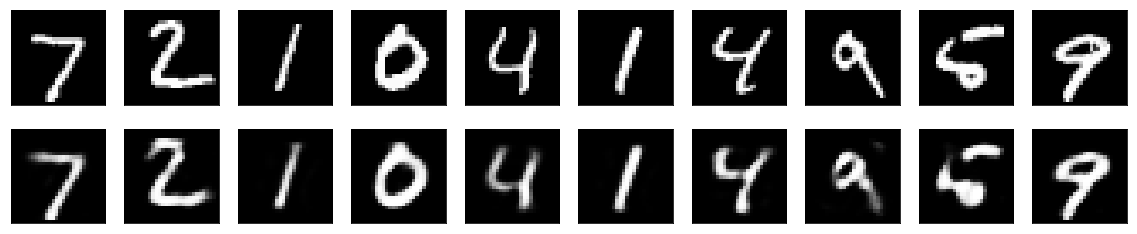

In [91]:
showimages(x_test, decoded_imgs)

## 2.2 稀疏自编码（对Encoder层的输出进行限制）
上面的自编码器是最基础的自编码器,当我们将中间的激活函数改为线性的激活函数,同时将输出的激活函数改为线性的激活函数之后,上述的自编码器等价于PCA(主成分分析),关于自编码器与SVD,PCA的关系的分析可以参考论文《Auto-association by multilayer perceptrons and singular value decomposition》[4]. 这一节我们在上一节的基础上对中间层进行进一步操作。我们强制要求中间层是稀疏的(此处我们通过加L1正则项来完成),换言之，每次操作中间隐藏单元中只有少数的单元会被激活,而这些激活的单元就是重点。在Keras中,该操作可以通过activity_regularizer函数来达到我们所需的目的。

In [94]:
from keras import regularizers

encoding_dim=32
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

print autoencoder.summary()

# define the encoder model
encoder = Model(input_img, encoded)

print encoder.summary()

# define the decoder model
encoded_input = Input(shape=(encoding_dim,))
decode_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decode_layer(encoded_input))

print decoder.summary()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print('X_train.shape:', x_train.shape, 'y_train.shape:', y_train.shape)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test, x_test))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_34 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params:

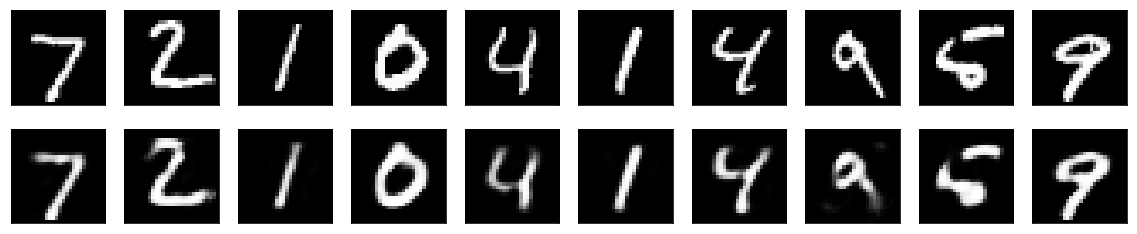

In [96]:
showimages(x_test, decoded_imgs)

貌似也没有什么太大的变化

# 2.3 深度自编码器(对编码器和解码器的网络的深度进行扩展)
上面的两个模型都是简单的两层网络,第一层用于编码,第二层用于解码。此处我们对自编码器的深度进行扩展

In [123]:

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print autoencoder.summary()

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs_deep = encoder.predict(x_test)
decoded_imgs_deep = decoder.predict(encoded_imgs_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_179 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_180 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_181 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_182 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_183 (Dense)            (None, 784)               101136    
Total para

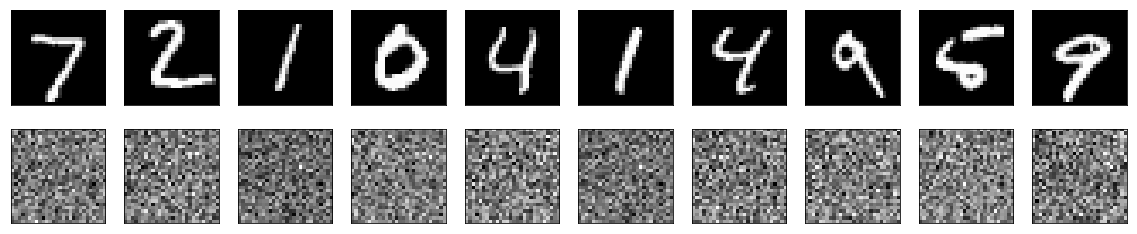

In [125]:
showimages(x_test, decoded_imgs_deep)

不知道为decode 出来这这个样子

## 2.4 深度卷积自编码器器

CNN是目前自然语言处理中和RNN并驾齐驱的两种最常见的深度学习模型。图1展示了在NLP任务中使用CNN模型的典型网络结构。一般而言，输入的字或者词用Word Embedding的方式表达，这样本来一维的文本信息输入就转换成了二维的输入结构，假设输入X包含m个字符，而每个字符的Word Embedding的长度为d，那么输入就是m*d的二维向量。
![](../data/images/CNN-with-Pooling.png)

下面这组动画很好的诠释了 "卷积"与 "Pooling层"的关系
![](../data/images/CNN-with-Pooling.gif)

这里可以看出，因为NLP中的句子长度是不同的，所以CNN的输入矩阵大小是不确定的，这取决于m的大小是多少。卷积层本质上是个特征抽取层，可以设定超参数F来指定设立多少个特征抽取器（Filter），对于某个Filter来说，可以想象有一个k*d大小的移动窗口从输入矩阵的第一个字开始不断往后移动，其中k是Filter指定的窗口大小，d是Word Embedding长度。对于某个时刻的窗口，通过神经网络的非线性变换，将这个窗口内的输入值转换为某个特征值，随着窗口不断往后移动，这个Filter对应的特征值不断产生，形成这个Filter的特征向量。这就是卷积层抽取特征的过程。每个Filter都如此操作，形成了不同的特征抽取器。Pooling 层则对Filter的特征进行降维操作，形成最终的特征。一般在Pooling层之后连接全联接层神经网络，形成最后的分类过程。



可见，卷积和Pooling是CNN中最重要的两个步骤。下面我们重点介绍NLP中CNN模型常见的Pooling操作方法。

**CNN中的Max Pooling Over Time操作**

MaxPooling Over Time是NLP中CNN模型中最常见的一种下采样操作。意思是对于某个Filter抽取到若干特征值，只取其中得分最大的那个值作为Pooling层保留值，其它特征值全部抛弃，值最大代表只保留这些特征中最强的，而抛弃其它弱的此类特征。



CNN中采用Max Pooling操作有几个好处：首先，这个操作可以保证特征的位置与旋转不变性，因为不论这个强特征在哪个位置出现，都会不考虑其出现位置而能把它提出来。对于图像处理来说这种位置与旋转不变性是很好的特性，但是对于NLP来说，这个特性其实并不一定是好事，因为在很多NLP的应用场合，特征的出现位置信息是很重要的，比如主语出现位置一般在句子头，宾语一般出现在句子尾等等，这些位置信息其实有时候对于分类任务来说还是很重要的，但是Max Pooling 基本把这些信息抛掉了。



其次，MaxPooling能减少模型参数数量，有利于减少模型过拟合问题。因为经过Pooling操作后，往往把2D或者1D的数组转换为单一数值，这样对于后续的Convolution层或者全联接隐层来说无疑单个Filter的参数或者隐层神经元个数就减少了。



 再者，对于NLP任务来说，Max Pooling有个额外的好处；在此处，可以把变长的输入X整理成固定长度的输入。因为CNN最后往往会接全联接层，而其神经元个数是需要事先定好的，如果输入是不定长的那么很难设计网络结构。前文说过,CNN模型的输入X长度是不确定的，而通过Pooling 操作，每个Filter固定取1个值，那么有多少个Filter，Pooling层就有多少个神经元，这样就可以把全联接层神经元个数固定住（如图2所示），这个优点也是非常重要的。
>Pooling层神经元个数等于Filters个数
> ![](../data/images/CNN-with-Pooling-02.png)
                       
**Max Pooling 缺点**

但是，CNN模型采取MaxPooling Over Time也有一些值得注意的缺点：首先就如上所述，特征的位置信息在这一步骤完全丢失。在卷积层其实是保留了特征的位置信息的，但是通过取唯一的最大值，现在在Pooling层只知道这个最大值是多少，但是其出现位置信息并没有保留；另外一个明显的缺点是：有时候有些强特征会出现多次，比如我们常见的TF-IDF公式，TF就是指某个特征出现的次数，出现次数越多说明这个特征越强，但是因为Max Pooling只保留一个最大值，所以即使某个特征出现多次，现在也只能看到一次，就是说同一特征的强度信息丢失了。这是Max Pooling Over Time典型的两个缺点。



其实，我们常说“危机危机”，对这个词汇乐观的解读是“危险就是机遇”。同理，发现模型的缺点是个好事情，因为创新往往就是通过改进模型的缺点而引发出来的。那么怎么改进Pooling层的机制能够缓解上述问题呢？下面两个常见的改进Pooling机制就是干这个事情的。

In [147]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28,28,1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2),)(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 4, 4, 8)           0         
__________

In [156]:
from keras.datasets import mnist
import numpy as np

(x_train,_), (x_test,_) = mnist.load_data()

print x_train.shape
print x_test.shape

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print x_train.shape
print x_test.shape


(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


open `terminal` and start the tensorboard
```bash
tensorboard --logdir=~/Downloads/autoencoder/
```

In [148]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='~/Downloads/autoencoder/')])


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 58s 974us/step - loss: 0.2141 - val_loss: 0.1449
Epoch 2/50
60000/60000 [==============================] - 56s 940us/step - loss: 0.1350 - val_loss: 0.1258
Epoch 3/50
60000/60000 [==============================] - 54s 902us/step - loss: 0.1226 - val_loss: 0.1178
Epoch 4/50
60000/60000 [==============================] - 54s 905us/step - loss: 0.1163 - val_loss: 0.1129
Epoch 5/50
60000/60000 [==============================] - 55s 923us/step - loss: 0.1121 - val_loss: 0.1093
Epoch 6/50
60000/60000 [==============================] - 55s 910us/step - loss: 0.1091 - val_loss: 0.1073
Epoch 7/50
60000/60000 [==============================] - 58s 971us/step - loss: 0.1069 - val_loss: 0.1048
Epoch 8/50
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1052 - val_loss: 0.1033
Epoch 9/50
60000/60000 [==============================] - 58s 967us/step - loss: 0.1038 - val_lo

当`TensorBoard`启动起来之后，就可以访问 http://0.0.0.0:6006/ 来看 `loss` and `val_loss`的变化曲线了!
![](../data/images/CNN_Tensorboard.png)

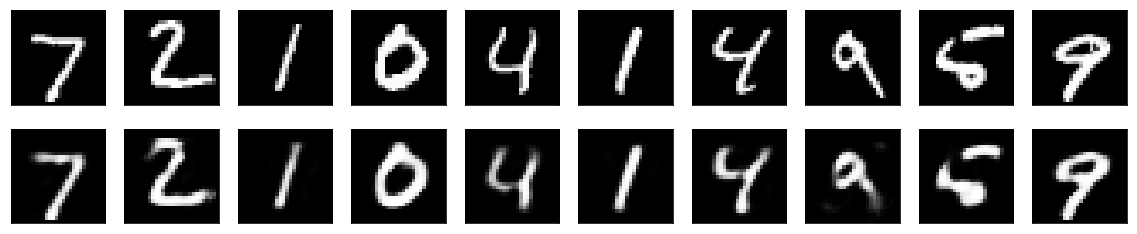

In [150]:
decode_imgs = autoencoder.predict(x_test)

showimages(x_test, decoded_imgs)

没什么太大的变化，但看上去经过 卷积之后的图片稍微清晰了一点点，但训练时间的确增加了不少!

# 2.5 去噪自编码器

去噪自编码器相比于上述的自编码器最大的区别就是在于我们将原始数据输入模型时,先对数据进行加噪处理,但是我们输出的label仍然是我们未加噪的数据,这样做的好处可以加到模型的鲁棒性

In [164]:
noise_factor = 0.5

x_train_noise = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noise = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noise = np.clip(x_train_noise, 0., 1.)
x_test_noise = np.clip(x_test_noise, 0., 1.)

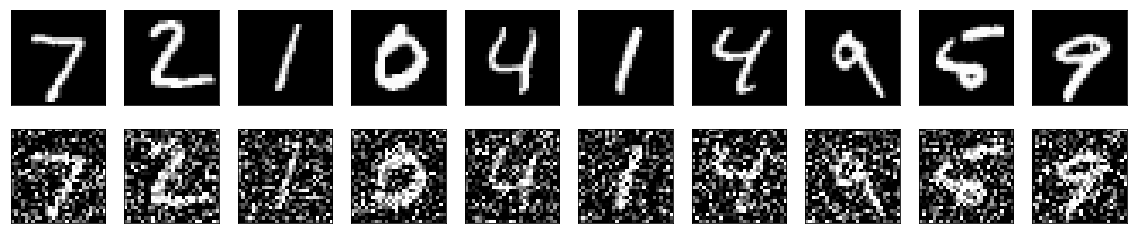

In [165]:
showimages(x_test, x_test_noise)

In [167]:
autoencoder.fit(x_train_noise, x_train, 
                epochs=5, 
                batch_size=128, 
                validation_data=(x_test_noise, x_test),
                callbacks=[TensorBoard(log_dir='~/Downloads/autoencoder')])


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 55s 923us/step - loss: 0.1238 - val_loss: 0.1210
Epoch 2/5
60000/60000 [==============================] - 59s 989us/step - loss: 0.1218 - val_loss: 0.1203
Epoch 3/5
60000/60000 [==============================] - 57s 957us/step - loss: 0.1213 - val_loss: 0.1198
Epoch 4/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1208 - val_loss: 0.1195
Epoch 5/5
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1205 - val_loss: 0.1195


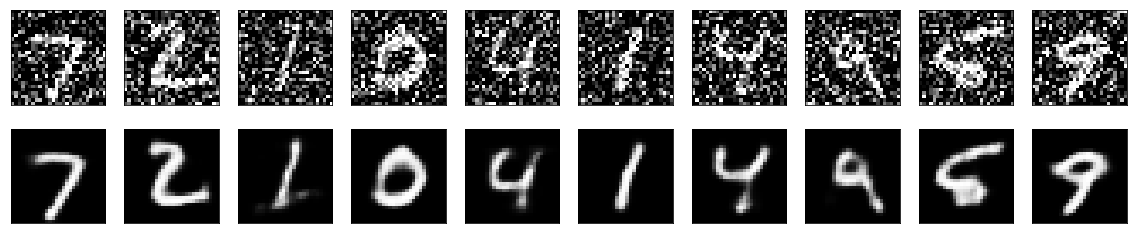

In [168]:
decoded_imgs_noised = autoencoder.predict(x_test_noise)

showimages(x_test_noise, decoded_imgs_noised)

 效果还是非常不错的！！！
 因为上面只轮了 5 个epoch, 如果轮的次数多一些，效果应该还会再好些！
 
 
 附上一张 TensorBoard图，一上面进行比较
 ![](../data/images/CNN_Tensorboard_with_noise.png)

【参考】

- https://blog.keras.io/building-autoencoders-in-keras.html
- https://www.kesci.com/apps/home/project/5a3902de0e1fc52691fdd5cb